#### resources
https://www.quora.com/Can-NLTK-be-used-for-multinomial-Naive-Bayes-classification

In [171]:
import sys
import os
import json

import nltk
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.model_selection import train_test_split as train_test_lit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from time import time

In [141]:
# function to plot confusion matrix 
def show_cf(y_true, y_pred, class_names=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names, rotation='vertical')
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

#useful tool
class classproperty(object):
    '''
    This is a helper that will be used as a decorator.
    Class property handling doesn't natively exist in Python.
    '''
    def __init__(self, getter):
        self.getter= getter
    def __get__(self, instance, owner):
        return self.getter(owner)

In [151]:
authors = [
    'Friedrich von Schiller',
    'Johann Wolfgang von Goethe',
    'Rainer Maria Rilke',
    'Franz Grillparzer',
    'Franz Kafka'
]

In [152]:
with open('stopwords-de-master/stopwords-de.json', 'r') as f:
    stopwords = json.load(f)

In [153]:
stopwords[0:5]

['a', 'ab', 'aber', 'ach', 'acht']

In [154]:
tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')
stemmer = SnowballStemmer(language = 'german')

In [221]:
class Book():
    _all = []
    
    @classmethod
    def add_to_all(cls,obj):
        if obj._str == None: #it's a book
            if obj.title not in [i.title for i in cls._all if i.author == obj.author]:
                cls._all.append(obj)
            else:
                print('Entry already exists.')
        elif obj._str not in [i._str for i in cls._all]: #it's a sample and it's not read in yet
            cls._all.append(obj)
        else:
            print('Entry already exists.')
        
    def __init__(self,author,title,_str=None):
        self._str = _str
        if title != None:
            self.title = title
        if author != None:
            self.author = author
        if (author != None) and (title != None):
            self.__class__.add_to_all(self)
            self.fpath = author + '/' + title
            
        #do the stuff
        self.read()
        self.tokenize()
        self.remove_symbols()
        self.remove_stopwords_and_stem(stemmer)

    @classproperty
    def all(cls):
        return pd.concat(
            pd.DataFrame(
                [[book.author,sentence] for sentence in book.sentences],
                columns = ['author','sentence']
            ) for book in cls._all)
    
    @classmethod
    def get_books(cls):
        for author in os.listdir('Authors'):
            if author != '.DS_Store': #not an author i'm familiar with
                for book in os.listdir('Authors/' + author):
                    Book(author,book.split('.')[0])
    
    def read(self):
        if self._str:
            self.text = self._str
        else:
            with open('./Authors/' + self.fpath + '.txt',encoding='iso-8859-1') as f:
                self.text = f.read()
            try:
                self.text = self.text.split('Falls Sie Fehler finden bitte bei DigBib.Org melden.')[1]
            except:
                pass
            self.text = self.text.replace('\n',' ')
    def tokenize(self):
        self.sentences = tokenizer.tokenize(self.text)
    
    def remove_symbols(self):
        for symbol in """“”<>{}[]&*^%$#@~`_+=-""'':;(),.?!''\n»«""":
            self.sentences = [sentence.replace(symbol, '').strip(' ') for sentence in self.sentences]
    def remove_stopwords_and_stem(self,stemmer):
        for i, sentence in enumerate(self.sentences):
            r = []
            for word in sentence.split():
                if word.lower() not in stopwords:
                    r.append(stemmer.stem(word.lower()))
            self.sentences[i] = ' '.join(r)
    

In [222]:
start = time()
Book.get_books()
print(time()-start)

15.941114902496338


In [157]:
df = Book.all
df = df[df.author.isin(authors)]
df.head()

,author,sentence
0,Franz Grillparzer,erzahl 1847 wien sonntag vollmond monat juli j...
1,Franz Grillparzer,volk besucht vornehm erschein eigenschaft glie...
2,Franz Grillparzer,moglich absonder
3,Franz Grillparzer,feiert augart leopoldstadt prat ununterbroch l...
4,Franz Grillparzer,brigittenkirchtag brigittenkirchtag zahlt gut ...


In [158]:
authors

['Friedrich von Schiller',
 'Johann Wolfgang von Goethe',
 'Rainer Maria Rilke',
 'Franz Grillparzer',
 'Franz Kafka']

---

In [159]:
tfidf = TfidfVectorizer()

In [160]:
tfidf.fit(df.sentence)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [164]:
tfidf_matrix = tfidf.transform(df.sentence)
target = df.author

X_train, X_test, y_train, y_test = train_test_lit( #🔥
    tfidf_matrix,
    target,
    stratify=target,
    test_size = 0.2
)

In [172]:
sm = SMOTE(sampling_strategy = 'not majority') 
X_train, y_train = sm.fit_resample(X_train,y_train)

In [173]:
clf = MNB()
clf.fit(X_train.todense(),y_train)
preds = clf.predict(X_test.todense()) 

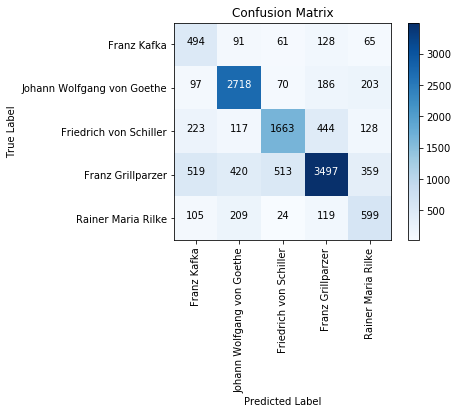

In [174]:
show_cf(y_test, preds) 


---

In [255]:
#inherit preprocessing
class Sample(Book):
    samples = []
    def __init__(self,_str):
        super(Sample,self).__init__(None,None,_str)
        self.tokenize()
        self.remove_symbols()
        self.remove_stopwords_and_stem(stemmer)
        Sample.samples.append(self)
    def predict(self,model):
        return model.predict(
            tfidf.transform(
                self.sentences
            ).todense()
        )[0] 

In [262]:
s = Sample('Bruder, sag mir, was für Bremsen? Mein Mercedes hält von selbst.')

In [263]:
s.predict(clf)

'Johann Wolfgang von Goethe'